In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import math
import os 
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.0.1+cu117


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
df_tr = pd.read_csv("train.csv")

In [4]:
missingIndex = df_tr[df_tr["MISSING_DATA"]].index
df_tr.drop(missingIndex, inplace=True)
print(df_tr.shape)

(1710660, 9)


In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

def startValX(polyline): 
    if (polyline == "[]"): 
        return 0
    res = polyline.split(",")
    res = res[0].replace('[', '')
    res = res.replace(']', '')
    res = float(res)
    return res

def startValY(polyline): 
    if (polyline == "[]"): 
        return 0
    res = polyline.split(",")
    res = res[1].replace('[', '')
    res = res.replace(']', '')
    res = float(res)
    return res

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)
# polylineItem = df_tr["POLYLINE"].apply(polyline_getItem)
df_tr["START_COORDX"] = df_tr["POLYLINE"].apply(startValX)
df_tr["START_COORDY"] = df_tr["POLYLINE"].apply(startValY)
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,START_COORDX,START_COORDY
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,-8.618643,41.141412
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-8.639847,41.159826
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,-8.612964,41.140359
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,-8.574678,41.151951
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,-8.645994,41.180490


In [6]:
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), dt.minute

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK", "MIN"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,START_COORDX,START_COORDY,YR,MON,DAY,HR,WK,MIN
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,-8.618643,41.141412,2013,7,1,0,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-8.639847,41.159826,2013,7,1,0,0,8
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,-8.612964,41.140359,2013,7,1,0,0,2
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,-8.574678,41.151951,2013,7,1,0,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,-8.645994,41.180490,2013,7,1,0,0,4


In [8]:
idMap = {}
for (i, id) in enumerate(np.unique(df_tr['TAXI_ID'])):
    idMap[id] = i

In [9]:
def applyMap(id):
    return idMap[id]
df_tr["TAXI_ID"] = df_tr["TAXI_ID"].apply(applyMap)

In [10]:
df_trimmed = df_tr.copy()

In [11]:
df_trimmed = df_trimmed.reset_index()

In [12]:
for colum in df_trimmed:
    unique_values = np.unique(df_trimmed[colum])
    nr_values = len(unique_values)
    if nr_values < 10:
        print("The number of unique values for features {} : {} --- {}".format(colum, nr_values,unique_values))
    elif nr_values == 19505: 
        nr_values_startx = unique_values
    elif nr_values == 15386:
        nr_values_starty = unique_values
    else:
         print("The number of unique values for features {} : {}".format(colum, nr_values))

full_rangex = nr_values_startx[-1] - nr_values_startx[0]
range_valuesx = []
range_valuesy = []
for i in nr_values_startx:
    if (i <= -9):
        range_valuesx.append(1)
    elif (i > -9 and i <= -8.7):
        range_valuesx.append(2)
    elif (i > -8.7 and i <= -8.6):
        range_valuesx.append(3)
    elif (i > -8.6 and i <= -8.5):
        range_valuesx.append(4)
    elif (i > -8.5 and i <= -8):
        range_valuesx.append(5)
    else:
        range_valuesx.append(6)
for i in nr_values_starty:
    if (i <= 37):
        range_valuesy.append(1)
    elif (i > 37 and i <= 40):
        range_valuesy.append(2)
    elif (i > 40 and i <= 41.25):
        range_valuesy.append(3)
    elif (i > 41.25 and i <= 43):
        range_valuesy.append(4)
    elif (i > 43 and i <= 44):
        range_valuesy.append(5)
    else:
        range_valuesy.append(6)

The number of unique values for features index : 1710660
The number of unique values for features TRIP_ID : 1710579
The number of unique values for features CALL_TYPE : 3 --- ['A' 'B' 'C']
The number of unique values for features ORIGIN_CALL : 57106
The number of unique values for features ORIGIN_STAND : 64
The number of unique values for features TAXI_ID : 448
The number of unique values for features TIMESTAMP : 1655357
The number of unique values for features DAY_TYPE : 1 --- ['A']
The number of unique values for features MISSING_DATA : 1 --- [False]
The number of unique values for features POLYLINE : 1703640
The number of unique values for features LEN : 1254
The number of unique values for features YR : 2 --- [2013 2014]
The number of unique values for features MON : 12
The number of unique values for features DAY : 31
The number of unique values for features HR : 24
The number of unique values for features WK : 7 --- [0 1 2 3 4 5 6]
The number of unique values for features MIN : 6

In [13]:
def rangeTypeX(polyline):
    if (polyline <= -9):
        return 1
    elif (polyline > -9 and polyline <= -8.7):
        return 2
    elif (polyline > -8.7 and polyline <= -8.6):
        return 3
    elif (polyline > -8.6 and polyline <= -8.5):
        return 4
    elif (polyline > -8.5 and polyline <= -8):
        return 5
    else:
        return 6

def rangeTypeY(polyline):
    if (polyline <= 37):
        return 1
    elif (polyline > 37 and polyline <= 40):
        return 2
    elif (polyline > 40 and polyline <= 41.25):
        return 3
    elif (polyline > 41.25 and polyline <= 43):
        return 4
    elif (polyline > 43 and polyline <= 44):
        return 5
    else:
        return 6

df_trimmed["STARTX"] = df_trimmed["START_COORDX"].apply(rangeTypeX)
df_trimmed["STARTY"] = df_trimmed["START_COORDY"].apply(rangeTypeY)

df_trimmed.tail()

,index,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,...,START_COORDX,START_COORDY,YR,MON,DAY,HR,WK,MIN,STARTX,STARTY
1710655,1710665,1404171463620000698,C,NaN,NaN,434,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",...,-8.612469,41.146020,2014,6,30,23,0,37,3,3
1710656,1710666,1404171367620000670,C,NaN,NaN,415,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",...,-8.610138,41.140845,2014,6,30,23,0,36,3,3
1710657,1710667,1388745716620000264,C,NaN,NaN,173,1388745716,A,False,[],...,0.000000,0.000000,2014,1,3,10,4,41,6,1
1710658,1710668,1404141826620000248,B,NaN,12.0,160,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",...,-8.630712,41.154885,2014,6,30,15,0,23,3,3
1710659,1710669,1404157147620000079,B,NaN,34.0,59,1404157147,A,False,"[[-8.615538,41.140629],[-8.615421,41.140746],[...",...,-8.615538,41.140629,2014,6,30,19,0,39,3,3


In [14]:
def transform(data, num_category):
    one_hot = np.zeros(num_category, dtype=np.float16)
    one_hot[data] = 1
    return one_hot

def transform60(data):
    return transform(data, 60)

def transform24(data):
    return transform(data, 24)

def transform12(data):
    return transform(data, 13)[1:13]

def transfrom7(data):
    return transform(data, 7)

def transform31(data):
    return transform(data, 32)[1:32]

def transform448(data):
    return transform(data, 448)

def transformCallType(data):
    if data == 'A':
        return (1,0,0)
    elif data == 'B':
        return (0,1,0)
    else :
        return (0,0,1)

def parseOriginCall(data):
    if data != data:
        res = 0
    else:
        res = 1
    return res

def parseOriginStand(data):
    if data != data:
        res = 0
    else:
        res = 1
    return res

def parseStartX(data):
    return transform(data-1, 6)

def parseStartY(data):
    return transform(data-1, 6)

In [17]:
def getFeatureVectors(dataframe):
    one_hot_hours = dataframe["HR"].apply(transform24)
    one_hot_month = dataframe["MON"].apply(transform12)
    call_type = dataframe["CALL_TYPE"].apply(transformCallType)
#     one_hot_min = dataframe["MIN"].apply(transform60)
    taxi_id = dataframe["TAXI_ID"].apply(transform448)
    one_hot_dow = dataframe["WK"].apply(transform12)
    one_hot_day = dataframe["DAY"].apply(transform31)
    o_call = dataframe["ORIGIN_CALL"].apply(parseOriginCall)
    o_stand = dataframe["ORIGIN_STAND"].apply(parseOriginStand)
    startX = dataframe["STARTX"].apply(parseStartX)
    startY = dataframe["STARTY"].apply(parseStartY)
    
    hours = torch.tensor(one_hot_hours, dtype=torch.float32)
    month = torch.tensor(one_hot_month, dtype=torch.float32)
    calls = torch.tensor(call_type, dtype=torch.float32)
#     minutes = torch.tensor(one_hot_min, dtype=torch.float32)
    dayofweek = torch.tensor(one_hot_dow, dtype = torch.float32)
    day = torch.tensor(one_hot_day, dtype = torch.float32)
    o_call = torch.tensor(o_call, dtype = torch.float32).reshape(-1,1)
    o_stand = torch.tensor(o_stand, dtype = torch.float32).reshape(-1,1)
    taxi_id = torch.tensor(taxi_id, dtype = torch.float32)
    startX = torch.tensor(startX, dtype = torch.float32)
    startY = torch.tensor(startY, dtype = torch.float32)
    
    fv = torch.cat((hours, month), dim=1)
    fv = torch.cat((fv, dayofweek), dim=1)
    fv = torch.cat((fv, day), dim=1)
    fv = torch.cat((fv, calls), dim=1)
    fv = torch.cat((fv, o_call), dim=1)
    fv = torch.cat((fv, o_stand), dim=1)
    fv = torch.cat((fv, taxi_id), dim=1)
    fv = torch.cat((fv, startX), dim=1)
    fv = torch.cat((fv, startY), dim=1)
    return fv

In [ ]:
raw_X = getFeatureVectors(df_trimmed)

/tmp/ipykernel_1251/2152340019.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  hours = torch.tensor(one_hot_hours, dtype=torch.float32)


In [16]:
#the y values will be the actual trip times
raw_y = torch.tensor(df_trimmed["LEN"].values, dtype=torch.float32)

In [17]:
print(f"{raw_X.shape=} {raw_X.size()=}") 
print(f"{raw_y.shape=} {raw_y.size()=}") 

raw_X.shape=torch.Size([1710660, 532]) raw_X.size()=torch.Size([1710660, 532])
raw_y.shape=torch.Size([1710660]) raw_y.size()=torch.Size([1710660])


In [18]:
#randomly populate the training and testing set with 1.5 million in the training and the rest in the testing
def sampleData(raw_X, raw_Y, length, numSample):
    perm = torch.randperm(length)
    train_idx, test_idx = perm[:int(numSample * 0.8)], perm[int(numSample * 0.8):numSample]
    X_tr, Y_tr = raw_X[train_idx], raw_Y[train_idx]
    X_te, Y_te = raw_X[test_idx], raw_Y[test_idx]
    return X_tr, Y_tr, X_te, Y_te

In [19]:
X_tr, Y_tr, X_te, Y_te = sampleData(raw_X, raw_y, len(df_trimmed), len(df_trimmed))

In [20]:
print(f"{X_tr.shape=} {X_te.shape=}") 
print(f"{Y_tr.shape=} {Y_te.size()=}") 

X_tr.shape=torch.Size([1368528, 532]) X_te.shape=torch.Size([342132, 532])
Y_tr.shape=torch.Size([1368528]) Y_te.size()=torch.Size([342132])


In [21]:
#do any reshapings that has to be done
X_train, X_test = X_tr.reshape((-1, 532)), X_te.reshape((-1, 532))
y_train, y_test = Y_tr.reshape((-1, 1)), Y_te.reshape((-1, 1))

In [22]:
print(f"{X_train.shape=} {X_test.shape=}") 
print(f"{y_train.shape=} {y_test.size()=}") 

X_train.shape=torch.Size([1368528, 532]) X_test.shape=torch.Size([342132, 532])
y_train.shape=torch.Size([1368528, 1]) y_test.size()=torch.Size([342132, 1])


In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(532, 1)
#         self.dropout = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(21, 1)
#         self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
#         x = self.fc1(x).reshape(1,43)
# #         x = F.normalize(x).reshape(-1)
#         print(x)
        x = self.fc1(x)
#         x = F.relu(self.fc3(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc1(x))
        return x


model = Net().to(device)

loss_fn = nn.MSELoss()

lr = 0.001
opt = optim.SGD(model.parameters(), lr=lr)

In [25]:
train_err = []
test_err = []
parameters = []
epoch = 100
batch_size = 1000
for i_epoch in range(epoch):
    permutation = torch.randperm(X_train.size()[0])
    running_loss = 0
    n = 0
    for i in range(0,X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)
        outputs = model(batch_x)
        loss = loss_fn(outputs,batch_y)
        running_loss += loss.item()
        n+=1
        opt.zero_grad() 
        loss.backward()
        opt.step()
    
    loss_rate = math.sqrt(running_loss / n)
    train_err.append(loss_rate)
    model.eval()
    with torch.no_grad():
        test_loss = math.sqrt(loss_fn(model(X_test.to(device)), y_test.to(device)).item())
        test_err.append(test_loss)
    if (i_epoch % 10 == 0):
        print("Epoch: {0} \t Training Loss: {1:.8f} \t Test Loss: {2:.8f}".format(i_epoch+1, loss_rate, test_loss))


Epoch: 1 	 Training Loss: 724.06561133 	 Test Loss: 674.67700606
Epoch: 11 	 Training Loss: 677.55841921 	 Test Loss: 667.05038696
Epoch: 21 	 Training Loss: 675.57168645 	 Test Loss: 665.11930321
Epoch: 31 	 Training Loss: 674.42568382 	 Test Loss: 663.87195207
Epoch: 41 	 Training Loss: 673.33132301 	 Test Loss: 662.89238380
Epoch: 51 	 Training Loss: 672.65530407 	 Test Loss: 662.07356559
Epoch: 61 	 Training Loss: 671.75993394 	 Test Loss: 661.37921705
Epoch: 71 	 Training Loss: 671.55064875 	 Test Loss: 660.78000783
Epoch: 81 	 Training Loss: 670.68788220 	 Test Loss: 660.25776217
Epoch: 91 	 Training Loss: 670.12698853 	 Test Loss: 659.80247991


In [26]:
print(train_err[-1], test_err[-1])

669.6913043962071 659.4345826160469


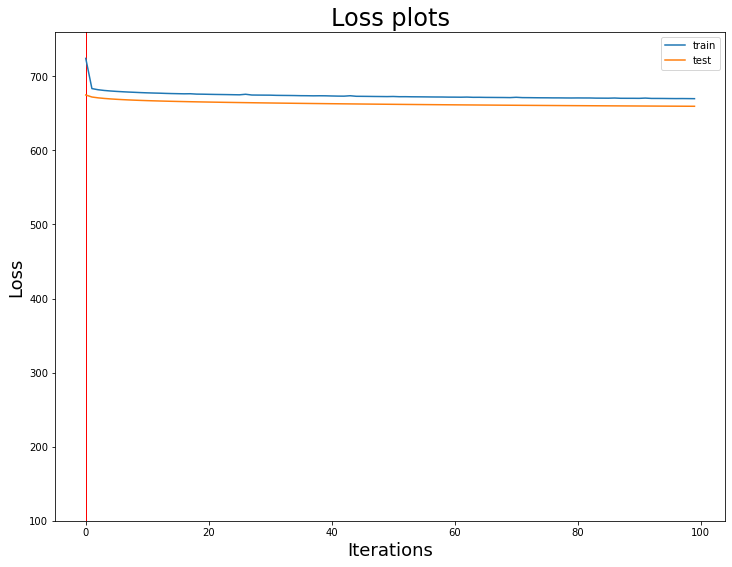

In [27]:
# print(train_err[epoch - 1 ])
# print(test_err[epoch - 1])

def visualize_graphs(train_err, test_err, title=""):
  plt.figure(figsize=(12,9))
  plt.axhline(color="red", lw=1)
  plt.axvline(color="red", lw=1)
  if title:
    plt.title(title, fontsize=24)
  plt.xlabel("Iterations", fontsize=18)
  plt.ylabel("Loss", fontsize=18)
  
  plt.plot(train_err, label="train")
  plt.plot(test_err, label="test")
  
  plt.ylim(100)
  
  plt.legend(loc="upper right")
  
  
visualize_graphs(train_err, test_err, "Loss plots")

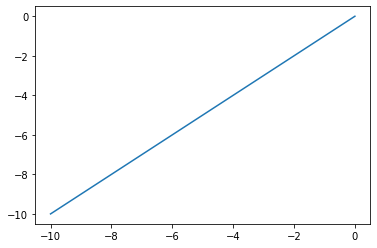

In [3]:
xpoints = np.array([-10, 0])
ypoints = np.array([-10, 0])
plt.plot(xpoints, ypoints)
plt.show()